In [1]:
!pip install transformers

In [2]:
import time
import random
import pandas as pd
from glob import glob
import argparse
import json
import subprocess
import sys
import os
import tensorflow as tf
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import DistilBertConfig

2024-01-11 12:50:29.041576: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Define the connection between Input data and Label

In [4]:
def select_data_and_label_from_record(record):
    x = {
        "input_ids": record["input_ids"],
        "input_mask": record["input_mask"],
    }
    y = record["label_ids"]

    return (x, y)

In [5]:
def file_based_input_dataset_builder(channel, input_filenames, max_seq_length, is_training, drop_remainder):
    # トレーニング時には並列読み出しとシャッフルを行う。
    # 評価時にはシャッフルは行わず、並列読み出しは効果がない。

    dataset = tf.data.TFRecordDataset(input_filenames)
    dataset = dataset.repeat(100)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    name_to_features = {
        "input_ids": tf.io.FixedLenFeature([max_seq_length], tf.int64),
        "input_mask": tf.io.FixedLenFeature([max_seq_length], tf.int64),
        "label_ids": tf.io.FixedLenFeature([], tf.int64),
    }

    def _decode_record(record, name_to_features):
        """Decodes a record to a TensorFlow example."""
        return tf.io.parse_single_example(record, name_to_features)

    dataset = dataset.apply(
        tf.data.experimental.map_and_batch(
            lambda record: _decode_record(record, name_to_features),
            batch_size=8,
            drop_remainder=drop_remainder,
            num_parallel_calls=tf.data.experimental.AUTOTUNE,
        )
    )

    dataset.cache()

    if is_training:
        dataset = dataset.shuffle(seed=42, buffer_size=10, reshuffle_each_iteration=True)

    return dataset

In [6]:
# train_data = "./data-tfrecord/bert-train"
train_data_filenames = "/mnt/train_data.tfrecord"
print("train_data_filenames {}".format(train_data_filenames))

train_dataset = file_based_input_dataset_builder(
    channel="train", 
    input_filenames=train_data_filenames, 
    max_seq_length=64, 
    is_training=True, 
    drop_remainder=False
).map(select_data_and_label_from_record)

train_data_filenames /mnt/train_data.tfrecord


2024-01-11 12:50:36.841686: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-11 12:50:37.019414: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-11 12:50:37.019710: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/s

Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


In [7]:
print(train_dataset)

<_MapDataset element_spec=({'input_ids': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_mask': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [8]:
# validation_data = "./data-tfrecord/bert-validation"
validation_data_filenames = "/mnt/validation_data.tfrecord"
print("validation_data_filenames {}".format(validation_data_filenames))

validation_dataset = file_based_input_dataset_builder(
    channel="validation",
    input_filenames=validation_data_filenames,
    max_seq_length=64,
    is_training=False,
    drop_remainder=False,
).map(select_data_and_label_from_record)

validation_data_filenames /mnt/validation_data.tfrecord


In [9]:
epochs = 1
steps_per_epoch = 1
validation_steps = 1
test_steps = 1
freeze_bert_layer = True
learning_rate = 3e-5
epsilon = 1e-08
max_seq_length = 64

In [10]:
CLASSES = [1, 2, 3, 4, 5]

config = DistilBertConfig.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(CLASSES),
    id2label={0: 1, 1: 2, 2: 3, 3: 4, 4: 5},
    label2id={1: 0, 2: 1, 3: 2, 4: 3, 5: 4},
)
print(config)

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": 1,
    "1": 2,
    "2": 3,
    "3": 4,
    "4": 5
  },
  "initializer_range": 0.02,
  "label2id": {
    "1": 0,
    "2": 1,
    "3": 2,
    "4": 3,
    "5": 4
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.36.2",
  "vocab_size": 30522
}



In [11]:
# Adding the layer for fine tuning on BERT

In [12]:
transformer_model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", config=config)

input_ids = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids", dtype="int32")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_mask", dtype="int32")

embedding_layer = transformer_model.distilbert(input_ids, attention_mask=input_mask)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(
    embedding_layer
)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(50, activation="relu")(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(len(CLASSES), activation="softmax")(X)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=X)

for layer in model.layers[:3]:
    layer.trainable = not freeze_bert_layer

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [13]:
# Set up the custom classifier model

In [14]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

metric = tf.keras.metrics.SparseCategoricalAccuracy("accuracy")

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=epsilon)

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 64)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 64)]         0           []                               
                                                                                                  
 distilbert (TFDistilBertMainLa  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 yer)                           ast_hidden_state=(N               'input_mask[0][0]']             
                                one, 64, 768),                                                    
                                 hidden_states=None                                           

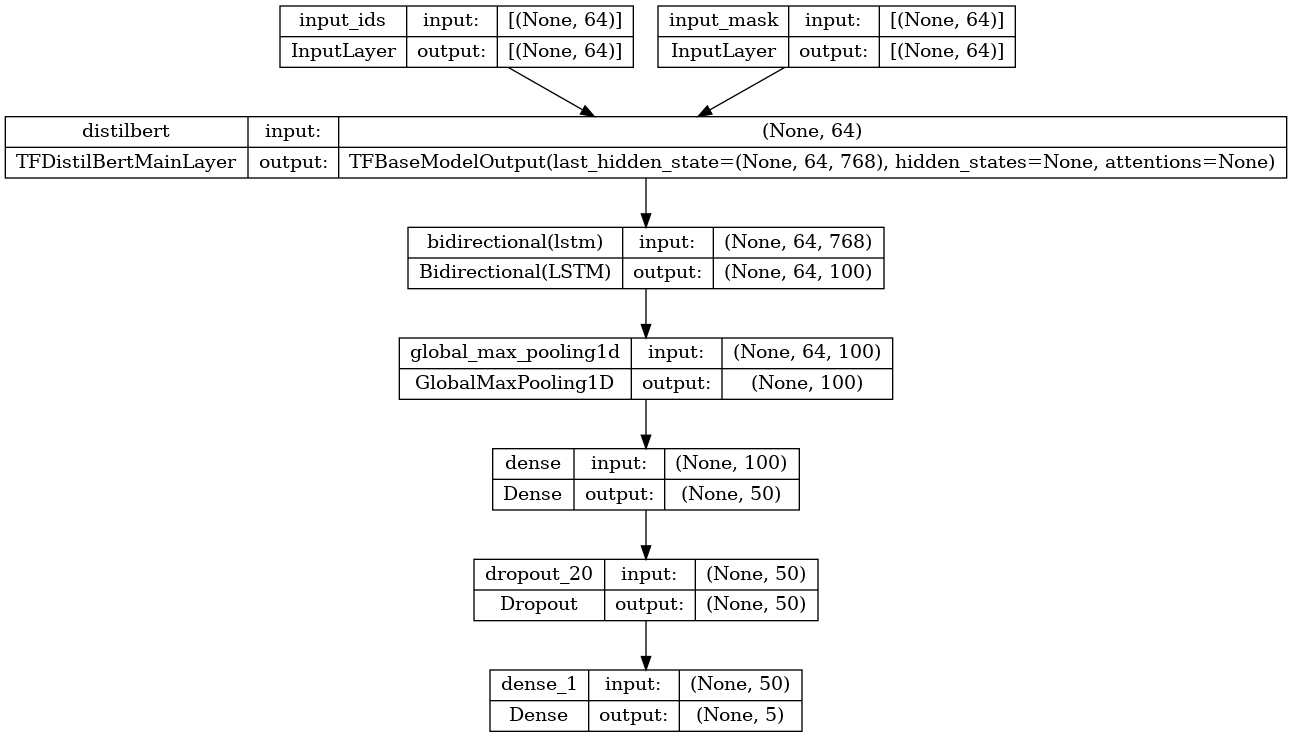

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

In [17]:
callbacks = []

log_dir = "./tmp/tensorboard/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callbacks.append(tensorboard_callback)

In [18]:
history = model.fit(
    train_dataset,
    shuffle=True,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    callbacks=callbacks,
)

2024-01-11 12:53:41.733379: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2024-01-11 12:53:41.733957: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-01-11 12:53:51.332

1/1 [==============================] - ETA: 0s - loss: 1.7334 - accuracy: 0.3750

2024-01-11 12:53:53.280872: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2024-01-11 12:53:53.281149: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 13s 13s/step - loss: 1.7334 - accuracy: 0.3750 - val_loss: 1.8967 - val_accuracy: 0.0000e+00


In [19]:
epochs = 128
steps_per_epoch = 128
validation_steps = 32
test_steps = 32
freeze_bert_layer = True
learning_rate = 3e-3
epsilon = 1e-08
max_seq_length = 64

In [20]:
history = model.fit(
    train_dataset,
    shuffle=True,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    callbacks=callbacks,
)

Epoch 1/128
128/128 [==============================] - 55s 427ms/step - loss: 1.6465 - accuracy: 0.2178 - val_loss: 1.6112 - val_accuracy: 0.1953
Epoch 2/128
128/128 [==============================] - 53s 414ms/step - loss: 1.6150 - accuracy: 0.2119 - val_loss: 1.5941 - val_accuracy: 0.2188
Epoch 3/128
128/128 [==============================] - 56s 442ms/step - loss: 1.5910 - accuracy: 0.2422 - val_loss: 1.5759 - val_accuracy: 0.2773
Epoch 4/128
128/128 [==============================] - 52s 408ms/step - loss: 1.5784 - accuracy: 0.2559 - val_loss: 1.5615 - val_accuracy: 0.2930
Epoch 5/128
128/128 [==============================] - 52s 405ms/step - loss: 1.5627 - accuracy: 0.2666 - val_loss: 1.5495 - val_accuracy: 0.2812
Epoch 6/128
128/128 [==============================] - 52s 403ms/step - loss: 1.5451 - accuracy: 0.2920 - val_loss: 1.5293 - val_accuracy: 0.3125
Epoch 7/128
128/128 [==============================] - 51s 401ms/step - loss: 1.5188 - accuracy: 0.3496 - val_loss: 1.5043 -

Epoch 57/128
128/128 [==============================] - 53s 412ms/step - loss: 1.2269 - accuracy: 0.4600 - val_loss: 1.2375 - val_accuracy: 0.4766
Epoch 58/128
128/128 [==============================] - 52s 408ms/step - loss: 1.2278 - accuracy: 0.4492 - val_loss: 1.2467 - val_accuracy: 0.4922
Epoch 59/128
128/128 [==============================] - 53s 416ms/step - loss: 1.2698 - accuracy: 0.4307 - val_loss: 1.2377 - val_accuracy: 0.4883
Epoch 60/128
128/128 [==============================] - 52s 405ms/step - loss: 1.2653 - accuracy: 0.4160 - val_loss: 1.2481 - val_accuracy: 0.4727
Epoch 61/128
128/128 [==============================] - 52s 409ms/step - loss: 1.1930 - accuracy: 0.4746 - val_loss: 1.2365 - val_accuracy: 0.4883
Epoch 62/128
128/128 [==============================] - 52s 407ms/step - loss: 1.2197 - accuracy: 0.4795 - val_loss: 1.2306 - val_accuracy: 0.4844
Epoch 63/128
128/128 [==============================] - 53s 415ms/step - loss: 1.2027 - accuracy: 0.4678 - val_loss: 1

128/128 [==============================] - 51s 398ms/step - loss: 1.2386 - accuracy: 0.4473 - val_loss: 1.2033 - val_accuracy: 0.5000
Epoch 113/128
128/128 [==============================] - 51s 401ms/step - loss: 1.2004 - accuracy: 0.4658 - val_loss: 1.2118 - val_accuracy: 0.5039
Epoch 114/128
128/128 [==============================] - 59s 465ms/step - loss: 1.2098 - accuracy: 0.4648 - val_loss: 1.2072 - val_accuracy: 0.5117
Epoch 115/128
128/128 [==============================] - 60s 469ms/step - loss: 1.1760 - accuracy: 0.4844 - val_loss: 1.2162 - val_accuracy: 0.4844
Epoch 116/128
128/128 [==============================] - 57s 443ms/step - loss: 1.1915 - accuracy: 0.4619 - val_loss: 1.2038 - val_accuracy: 0.4961
Epoch 117/128
128/128 [==============================] - 57s 443ms/step - loss: 1.2073 - accuracy: 0.4531 - val_loss: 1.2047 - val_accuracy: 0.5000
Epoch 118/128
128/128 [==============================] - 54s 424ms/step - loss: 1.1785 - accuracy: 0.4893 - val_loss: 1.2233 -

In [21]:
print(history.history)

{'loss': [1.6465128660202026, 1.6149929761886597, 1.5909533500671387, 1.5784475803375244, 1.5626575946807861, 1.5451279878616333, 1.5188071727752686, 1.493934154510498, 1.477505087852478, 1.4628187417984009, 1.4242994785308838, 1.4068212509155273, 1.3973528146743774, 1.3633133172988892, 1.4072461128234863, 1.3674654960632324, 1.3488496541976929, 1.3192110061645508, 1.3253452777862549, 1.3193036317825317, 1.3106876611709595, 1.303633213043213, 1.284691333770752, 1.285010814666748, 1.2986204624176025, 1.2885321378707886, 1.3311378955841064, 1.244496464729309, 1.2798619270324707, 1.2750788927078247, 1.28500497341156, 1.2504940032958984, 1.2260329723358154, 1.2781085968017578, 1.2439460754394531, 1.2491835355758667, 1.2320809364318848, 1.2673053741455078, 1.2481263875961304, 1.2637251615524292, 1.2759037017822266, 1.2432706356048584, 1.2223690748214722, 1.2326788902282715, 1.2464735507965088, 1.2302310466766357, 1.2618217468261719, 1.193912386894226, 1.2223689556121826, 1.2408034801483154,

In [22]:
import pandas as pd
import numpy as np

from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def predict(text):
    encode_plus_tokens = tokenizer.encode_plus(
                            text,
                            pad_to_max_length=True,
                            max_length=max_seq_length,
                            truncation=True,
                            return_tensors='tf')
    
    input_ids = encode_plus_tokens['input_ids']
    input_mask = encode_plus_tokens['attention_mask']
    
    outputs = model.predict(x=(input_ids,input_mask))
    
    prediction = [{"label":config.id2label[item.argmax()], \
                   "socre":item.max().item()} for item in outputs]

    return prediction[0]

In [23]:
# Adhoc predict

In [24]:
predict("This is great!")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


1/1 [==============================] - 2s 2s/step


{'label': 5, 'socre': 0.8343484997749329}

In [25]:
predict("This is cool.")

1/1 [==============================] - 0s 72ms/step


{'label': 5, 'socre': 0.45165207982063293}

In [26]:
predict("I don't like this.")

1/1 [==============================] - 0s 67ms/step


{'label': 1, 'socre': 0.5401071906089783}

In [38]:
predict("I might buy it again.")

1/1 [==============================] - 0s 69ms/step


{'label': 3, 'socre': 0.3027340769767761}

In [33]:
predict("The color is a little bit different from the picture. But it is OK.")

1/1 [==============================] - 0s 80ms/step


{'label': 3, 'socre': 0.48452121019363403}

In [39]:
def plot_accracy(history):
    import matplotlib.pyplot as plt

    # Setting Parameters
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    # 1) Accracy Plt
    plt.plot(epochs, acc, 'bo' ,label = 'training accuracy')
    plt.plot(epochs, val_acc, 'b' , label= 'validation accuracy')
    plt.title('Training and Validation acc')
    plt.legend()

    plt.figure()

    # 2) Loss Plt
    plt.plot(epochs, loss, 'bo' ,label = 'training loss')
    plt.plot(epochs, val_loss, 'b' , label= 'validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.show()

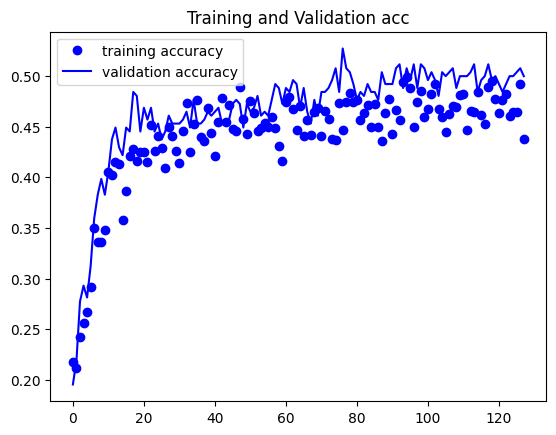

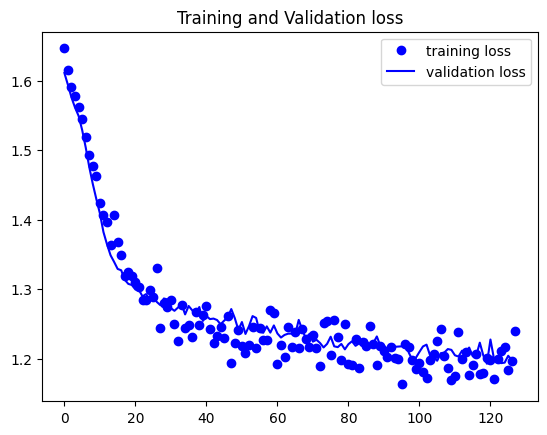

In [40]:
from keras import models 
from keras import layers
from keras import optimizers

#show Accuracy and Loss History
#「loss」と「val_loss」の違いですが、「loss」は学習時のlossの値で、正解と予測の差分です。この値を少なくするように学習を進めます。
#「val_loss」は検証用データでlossを計算した値です。
# モデルは「loss」の値を少なくするように学習データを使用して学習を進めます。ただし学習データのみを使用して学習するため、学習データのみ 
# にあてはまり新たなデータでうまく予測できなくなる、いわゆるオーバーフィッティング状態になることがあります。
# グラフ上では「loss」が下がっていくのに「val_loss」が上がってしまう状態です。
plot_accracy(history)

In [41]:
df = pd.read_parquet("/mnt/amazon_reviews_2015.snappy.parquet",columns=["star_rating","review_id","review_body"])

In [42]:
for i in range(1,6):
    new_df = 'df' + str(i)
    globals()[new_df] = df[df['star_rating'] == i].sample(n=200)

In [43]:
test_df = pd.concat([df1,df2,df3,df4,df5])

In [44]:
test_df.count()

star_rating    1000
review_id      1000
review_body    1000
dtype: int64

In [45]:
test_df['review_id'] = test_df['review_id'].str.decode("utf-8")

In [46]:
test_df['review_body'] = test_df['review_body'].str.decode("utf-8","ignore")

In [47]:
test_df

,star_rating,review_id,review_body
4803717,1,R2H28MQ9OE9NO2,It came rusty on the inside. One half of the i...
17838533,1,R3NAQQ2CN5YWHC,This outdated booklet is misrepresented as a b...
26821702,1,R8MHYH6NIE4FN,Item stopped working - beyoned 30 day policy g...
7912103,1,R1QOZ485C3W647,Don't waste your money!!! broke right in half ...
14948610,1,R3QYK6DAT2BU0N,The fabric was so rotten that I couldn't put i...
...,...,...,...
14458560,5,RTYESVGSOLEZG,I love this top it's comfortable and stylish w...
37357326,5,R1XQ30XXEF76XO,GREAT!
26367716,5,R23G42YWGQSLLV,These look so cute on my granddaughter! She lo...
22886523,5,RGRA8R6NRUASF,Better then expected!!!


In [48]:
y_test = test_df['review_body'].map(predict)
y_true = test_df['star_rating']

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 59ms/step


In [49]:
print(type(y_test))
y_test2 = [x.get('label') for x in y_test.values]

<class 'pandas.core.series.Series'>


In [50]:
print(type(y_test2))
print(y_test2)

<class 'list'>
[1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 3, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 3, 2, 1, 1, 2, 1, 1, 1, 1, 5, 1, 1, 3, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 4, 1, 1, 2, 5, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 2, 1, 3, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 3, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 4, 2, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 3, 1, 2, 2, 1, 1, 1, 4, 1, 1, 1, 2, 1, 2, 1, 1, 4, 1, 3, 1, 3, 4, 3, 1, 5, 2, 3, 1, 2, 2, 2, 1, 1, 1, 1, 3, 2, 2, 2, 2, 1, 3, 1, 1, 2, 3, 2, 2, 2, 2, 3, 4, 3, 1, 2, 3, 2, 3, 2, 3, 4, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 3, 2, 2, 2, 4, 2, 4, 3, 2, 2, 4, 2, 2, 4, 2, 2, 1, 4, 3, 4, 2, 2, 3, 1, 4, 2, 4, 2, 3, 1, 2, 1, 1, 1, 1, 1, 4, 2, 2, 5, 1, 4, 3, 2, 2, 3, 

In [51]:
print(type(y_true))
y_true2 = [x for x in y_true.values]

<class 'pandas.core.series.Series'>


In [52]:
print(type(y_true2))
print(y_true2)

<class 'list'>
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [115]:
!pip uninstall -y matplotlib

Found existing installation: matplotlib 3.5.0
Uninstalling matplotlib-3.5.0:
  Successfully uninstalled matplotlib-3.5.0


In [128]:
!pip install matplotlib==3.7.3

In [127]:
!pip install seaborn==0.12.2

  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.1
    Uninstalling seaborn-0.13.1:
      Successfully uninstalled seaborn-0.13.1


In [129]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#print(CLASSES)
cm = confusion_matrix(y_test2, y_true2, labels=CLASSES)
cm

array([[145,  66,  23,   7,   4],
       [ 41,  74,  58,  17,   2],
       [  9,  38,  63,  38,  10],
       [  2,  20,  42,  81,  52],
       [  3,   2,  14,  57, 132]])

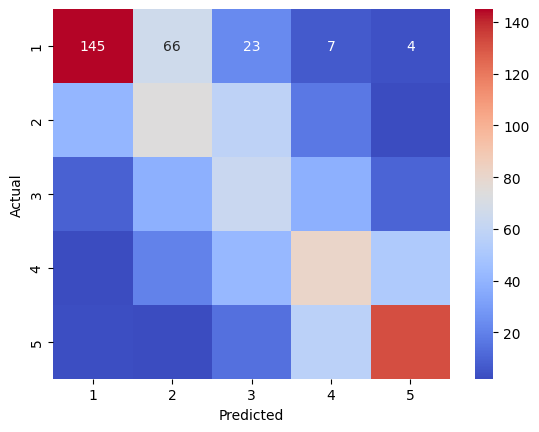

In [130]:
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [82]:
model.save('/mnt/tensorflow/',save_format='tf')

2024-01-11 15:10:12.354863: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'while/Placeholder_2' with dtype float and shape [?,50]
	 [[{{node while/Placeholder_2}}]]
2024-01-11 15:10:12.471496: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'while/Placeholder_2' with dtype float and shape [?,50]
	 [[{{node while/Placeholder_2}}]]
2024-01-11 15:10:12.498945: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and sh

2024-01-11 15:10:16.918715: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64,768]
	 [[{{node inputs}}]]
2024-01-11 15:10:16.937977: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64,768]
	 [[{{node inputs}}]]
2024-01-11 15:10:16.950190: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,50]
	 [[{{node inputs}}]]
2024-01-11 

INFO:tensorflow:Assets written to: /mnt/tensorflow/assets


INFO:tensorflow:Assets written to: /mnt/tensorflow/assets


In [83]:
!ls -l /mnt/tensorflow

total 4912
drwxr-xr-x 2 root root    4096 Jan  9 10:42 assets
-rw-r--r-- 1 root root      56 Jan 11 15:10 fingerprint.pb
-rw-r--r-- 1 root root   98619 Jan 11 15:10 keras_metadata.pb
-rw-r--r-- 1 root root 4914311 Jan 11 15:10 saved_model.pb
drwxr-xr-x 2 root root    4096 Jan 11 15:10 variables


In [58]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>